In [18]:
# Imports
import torch
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

import sys
import random
from random import randint

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from captum.attr import LayerGradCam, FeatureAblation, LayerActivation, IntegratedGradients, GradientShap, Saliency, NoiseTunnel

from functools import partial

# Add the upper directory to the path
sys.path.append("../models/")
from CustomCNNVessel import CustomResNet

sys.path.append("../data/")
from VessMapDatasetLoader import vess_map_dataloader

torch.cuda.empty_cache()
device = 'cpu'

In [19]:
# Dataloaders
image_dir = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap/images'
mask_dir = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap/labels'
skeleton_dir = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap/skeletons'

batch_size = 10
train_size = 0.8

In [20]:
train_loader, test_loader = vess_map_dataloader(image_dir, 
                                  mask_dir, 
                                  skeleton_dir, 
                                  batch_size,
                                  train_size = train_size,
                                  image_size = 224)

In [21]:
# Concating images
all_images = []
all_masks = []
all_skeletons = []

# Iterate through the entire train_loader
for batch in train_loader:
    images, masks, skeletons = batch
    images, masks, skeletons = images.to(device), masks.to(device), skeletons.to(device)

    all_images.extend(images)
    all_masks.extend(masks)
    all_skeletons.extend(skeletons)
    
for batch in test_loader:
    images, masks, skeletons = batch
    images, masks, skeletons = images.to(device), masks.to(device), skeletons.to(device)

    all_images.extend(images)
    all_masks.extend(masks)
    all_skeletons.extend(skeletons)

In [22]:
# Models
model = CustomResNet(num_classes=2).to(device)
# Load the weights
model.load_state_dict(torch.load(f"../models/vess_map_regularized_none_200.pth"))

model_regularized_l1 = CustomResNet(num_classes=2).to(device)
# Load the weights
model_regularized_l1.load_state_dict(torch.load(f"../models/vess_map_regularized_l1_200.pth"))

model_regularized_l2 = CustomResNet(num_classes=2).to(device)
# Load the weights
model_regularized_l2.load_state_dict(torch.load(f"../models/vess_map_regularized_l2_200.pth"))

model = model.eval()
model_regularized_l1 = model_regularized_l1.eval()
model_regularized_l2 = model_regularized_l2.eval()

In [23]:
class SegmentationAttribution:
    def __init__(self, model, images, skeletons = None, masks=None, device="cpu"):
        self.model = model.to(device)
        self.images = [img.to(device) for img in images]
        self.skeletons = skeletons
        self.masks = masks
        self.device = device
        self.out_maxes = []
    
    # Gets randomly the coordinate of a pixel with positive score for the given target
    def positive_score(self, out, target = 1, seed = 42):
      search_domain = out[0, :, :]
      
      random.seed(seed * 0.5)
      for i in range(randint(0, search_domain.shape[0]), search_domain.shape[0]):
        random.seed(seed * 0.2)
        for j in range(randint(0, search_domain.shape[0]), search_domain.shape[1]):
                if search_domain[i, j] > 0:
                    return (i, j)
      return None

    # For all the images apply the given model
    def apply_model(self):
        for img in self.images:
            input_tensor = img.unsqueeze(0)
            output = self.model(input_tensor)
            out_max = torch.argmax(output, dim=1, keepdim=True)
            self.out_maxes.append(out_max)

    # Mean of attribution maps wrapper function
    def agg_segmentation_wrapper(self, inp, out_max):
        model_out = self.model(inp)
        selected_inds = torch.zeros_like(model_out[0:1]).scatter_(1, out_max, 1)
        return (model_out * selected_inds).sum(dim=(2,3))

    # Given pixel wrapper function
    def pixels_wrapper(self, inp,):
        model_out = self.model(inp)
        return (model_out[0:1, :, self.p_height, self.p_width])

    # Region from a given pixel wrapper function
    def region_pixels_wrapper(self, inp,):
        model_out = self.model(inp)
        return (model_out[0:1, :, self.p_height-5:self.p_height+5, self.p_width-5:self.p_width+5])


    def compute_attributions(self, method, layer, tgt, n_steps=10, baselines=None, wrapper_type="pix", noise_tunnel=False, noise_tunnel_params=None, variations=None):
        method_instance = {
            'Saliency': Saliency,
            'LayerGradCam': LayerGradCam,
            'LayerActivation': LayerActivation,
            'FeatureAblation': FeatureAblation,
            'IntegratedGradients': partial(IntegratedGradients, multiply_by_inputs=False),
            'GradientShap': GradientShap
        }[method]

        self.centroids = []
        if method == "IntegratedGradients":
            self.model.eval()
            if baselines is None:
                baselines = torch.zeros_like(self.images[0].unsqueeze(0))

        attrs = []
        for idx, (img, out_max) in enumerate(zip(self.images, self.out_maxes)):
            input_tensor = img.unsqueeze(0)
            if wrapper_type == "agg":
                wrapper_func = lambda inp: self.agg_segmentation_wrapper(inp, out_max)
            elif wrapper_type == "pix":
                self.p_height, self.p_width = self.positive_score(self.skeletons[idx], 1)
                wrapper_func = self.pixels_wrapper
                self.centroids.append((self.p_width, self.p_height))
                
            elif wrapper_type == "pix_region":
                self.p_height, self.p_width = self.positive_score(self.skeletons[idx], 1)
                wrapper_func = self.pixels_wrapper
                self.centroids.append((self.p_width, self.p_height))

            try:
                attr_method = method_instance(wrapper_func, layer)
            except:
                attr_method = method_instance(wrapper_func)
            
            if noise_tunnel:
                for var_params in variations:
                    nt_type = var_params['nt_type']
                    stdevs = var_params['stdevs']
                    nt_samples = var_params['nt_samples']
                    
                    attr_method = NoiseTunnel(attr_method)

            if method == "FeatureAblation":
                attr = attr_method.attribute(input_tensor,
                                             feature_mask=out_max, 
                                             target=tgt)

            elif method == "IntegratedGradients":
                attr, _ = attr_method.attribute(input_tensor, 
                                                target=tgt, baselines=baselines, method='gausslegendre',
                                                return_convergence_delta=True, n_steps=n_steps)
                
            elif method == "LayerActivation":
                attr = attr_method.attribute(input_tensor)
                attr = attr[:, tgt, :, :].unsqueeze(0)

            elif method == "GradientShap":
                if baselines is None:
                    baselines = torch.zeros_like(self.images[0].unsqueeze(0))
                attr = attr_method.attribute(input_tensor, target=tgt, baselines=baselines)

            elif method == "Saliency":
                if noise_tunnel:
                    attr = attr_method.attribute(input_tensor,target=tgt, abs=False, nt_type=nt_type,stdevs=stdevs, nt_samples=nt_samples)
                else:
                    attr = attr_method.attribute(input_tensor,target=tgt, abs=False)
                
            else:
                attr = attr_method.attribute(input_tensor, target=tgt)
                
            attrs.append(attr)
        return attrs
    
    def plot_attributions(self, attributions, wrapper_type="pix", save_path=None, title=None):
        num_images = len(self.images)
        
        subplot_size = (4, 4) 
        
        total_width = num_images * subplot_size[0]
        total_height = num_images / 2 * subplot_size[1]

        plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.5, wspace=0.2)  

        num_rows = (num_images // 5) + int(num_images % 5 != 0)
        fig, axes = plt.subplots(nrows=num_rows, ncols=8, figsize=(12, 9))  

        if num_rows == 1:
            axes = [axes]

        for idx, (attr, img) in enumerate(zip(attributions, self.images)):
            row = idx // 4
            col = (idx % 4) * 2  

            # Original Image
            axes[row][col].imshow(img.detach().cpu().numpy().transpose(1, 2, 0), cmap='gray')
            if wrapper_type == "pix":
                axes[row][col].scatter(*self.centroids[idx], marker='.', c='blue', s=10)
            axes[row][col].set_title("Original Image")
            
            axes[row][col].axis('off')

            # Attribution Map
            im = axes[row][col+1].imshow(attr[0].cpu().permute(1,2,0).detach().numpy(), cmap='RdYlGn')
            if wrapper_type == "pix":
                centroid_title = f"Attribution Map\nCentroid: {self.centroids[idx]}"
                axes[row][col+1].scatter(*self.centroids[idx], marker='.', c='blue', s=3)
                axes[row][col+1].set_xlim((self.centroids[idx][0] - 20, self.centroids[idx][0] + 20))
                axes[row][col+1].set_ylim((self.centroids[idx][1] - 20, self.centroids[idx][1] + 20))

                
            else:
                centroid_title = "Attribution Map"
            axes[row][col+1].set_title(centroid_title)
            axes[row][col+1].set_title("Attribution Map")
            axes[row][col+1].axis('off')

            # Colorbar
            divider = make_axes_locatable(axes[row][col+1])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, ax=axes[row][col+1], cax=cax, orientation='vertical')

        """ if title:
            fig.suptitle(title, fontsize=16) """

        if save_path:
            plt.savefig(save_path, format='pdf')

        plt.tight_layout()
        plt.show()
    
    def plot_attributions_simple(self, attributions, images, title):
        num_images = 6  # Total of 6 images
        fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(18, 6))  # Two rows and six columns
        
        for idx in range(num_images):
            row = idx // 3
            col = idx % 3 * 2  # Multiply by 2 to leave space for attribution maps next to each image
            
            # Original Image
            ax_img = axes[row, col]  # Even column in the row
            img = images[idx]
            ax_img.imshow(img.detach().cpu().numpy().transpose(1, 2, 0), cmap='gray')
            ax_img.axis('off')
            ax_img.set_title("Imagem Original " + str(idx + 1))
            
            # Attribution Map
            ax_attr = axes[row, col + 1]  # Odd column next to the image
            attr = attributions[idx]
            im = ax_attr.imshow(attr[0].cpu().permute(1, 2, 0).detach().numpy(), cmap='RdYlGn')
            ax_attr.axis('off')
            ax_attr.set_title("Mapa de Ativação " + str(idx + 1))
            
            # Adding a colorbar to each attribution map
            cbar = fig.colorbar(im, ax=ax_attr, fraction=0.046, pad=0.04)
        fig.suptitle(title) 
        plt.tight_layout()
        plt.savefig(f'/home/fonta42/Desktop/imagens-ic-relatorio-final/{title}.pdf', format='pdf')
        plt.show()

In [24]:
input_images = all_images[:6]
input_skeletons = all_skeletons[:6] 
input_masks = all_masks[:6] 

seg_attr = SegmentationAttribution(model, input_images, input_skeletons, input_masks, device='cpu')
seg_attr.apply_model()

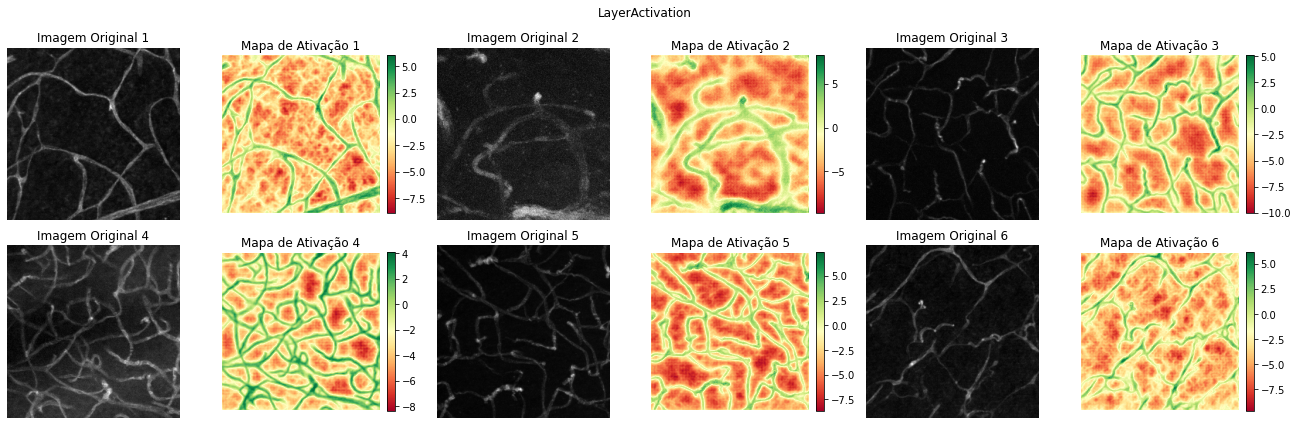

In [25]:
# LayerActivation method
path = "../attributions_maps/vessels/"
target = 1
dataset_type = 'vess_map'
# Usage
attributions = seg_attr.compute_attributions('LayerActivation', 
                                             model.final, 
                                             tgt=target,
                                             noise_tunnel = False)

seg_attr.plot_attributions_simple(attributions, input_images, title = 'LayerActivation' ) 

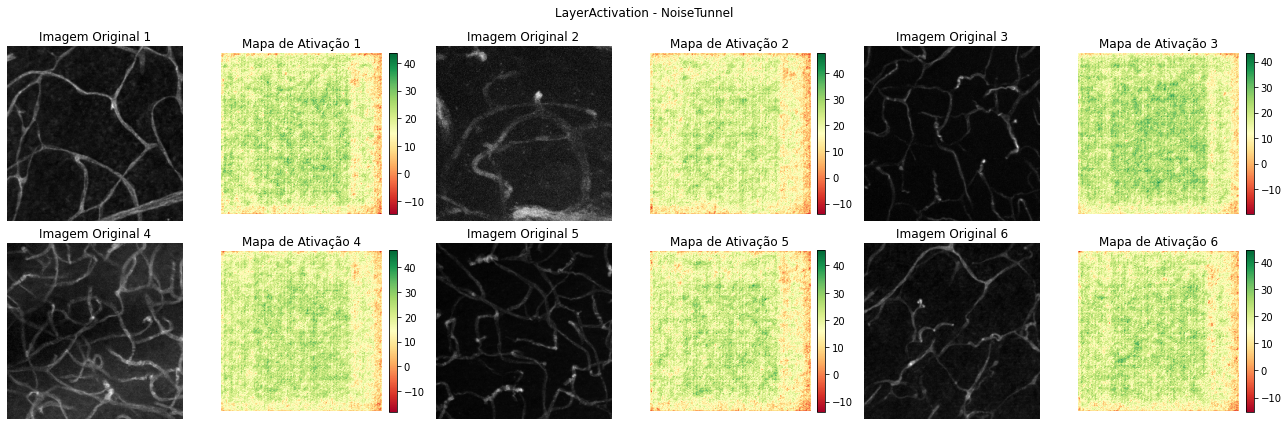

In [26]:
# LayerActivation method
path = "../attributions_maps/vessels/"
target = 1
dataset_type = 'vess_map'
nt_variations = {'nt_type': 'smoothgrad_sq', 'stdevs': 1., 'nt_samples': 50} 

# Usage
attributions = seg_attr.compute_attributions('LayerActivation', 
                                             model.final, 
                                             tgt=target,
                                             noise_tunnel = True,
                                             noise_tunnel_params=nt_variations,
                                             variations=[nt_variations])

seg_attr.plot_attributions_simple(attributions, input_images, title = 'LayerActivation - NoiseTunnel' ) 

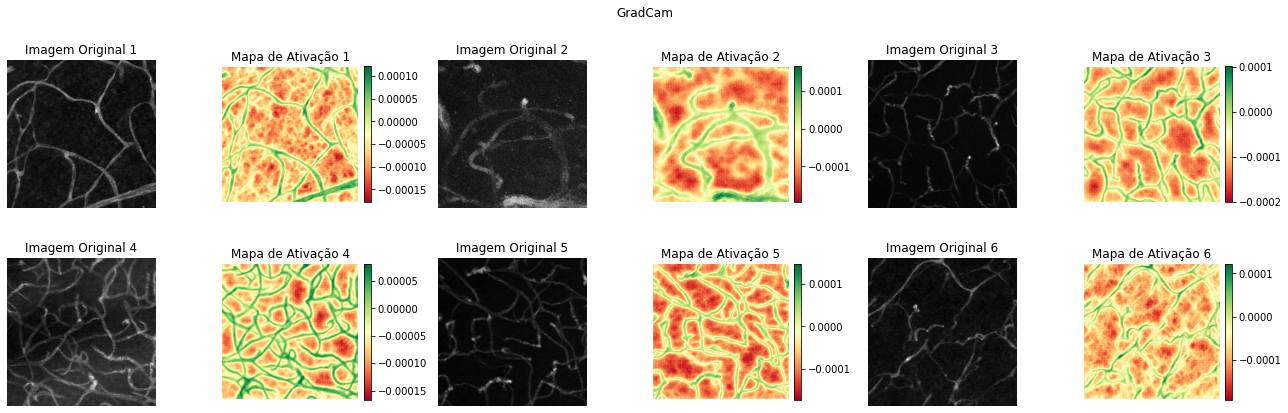

In [27]:
# GradCam method
path = "../attributions_maps/vessels/"
target = 1
dataset_type = 'vess_map'
# Usage
attributions = seg_attr.compute_attributions('LayerGradCam', 
                                             model.final, 
                                             tgt=target,
                                             noise_tunnel = False)


seg_attr.plot_attributions_simple(attributions, input_images, title = 'GradCam' )

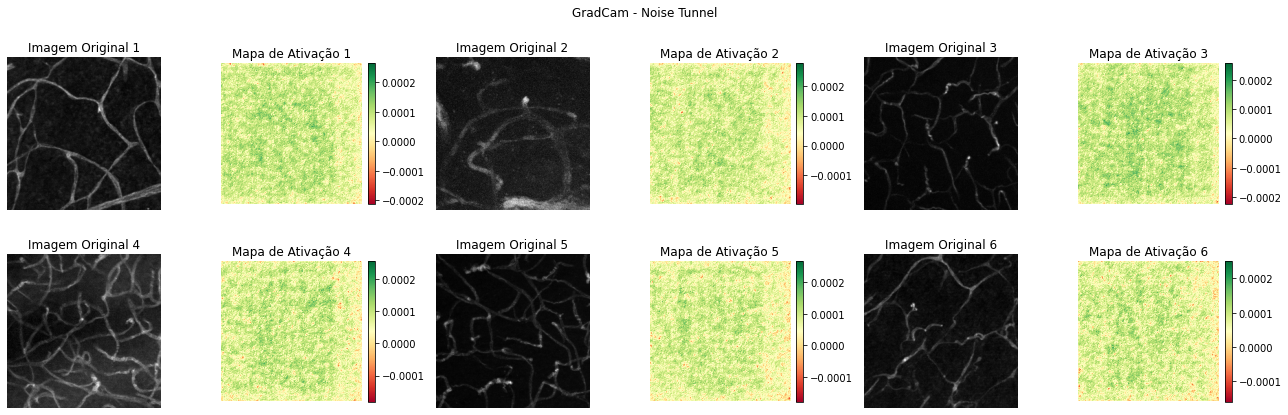

In [28]:
# GradCam method
path = "../attributions_maps/vessels/"
target = 1
dataset_type = 'vess_map'
# Usage
attributions = seg_attr.compute_attributions('LayerGradCam', 
                                             model.final, 
                                             tgt=target,
                                             noise_tunnel = True,
                                             noise_tunnel_params=nt_variations,
                                             variations=[nt_variations])


seg_attr.plot_attributions_simple(attributions, input_images, title = 'GradCam - Noise Tunnel' )

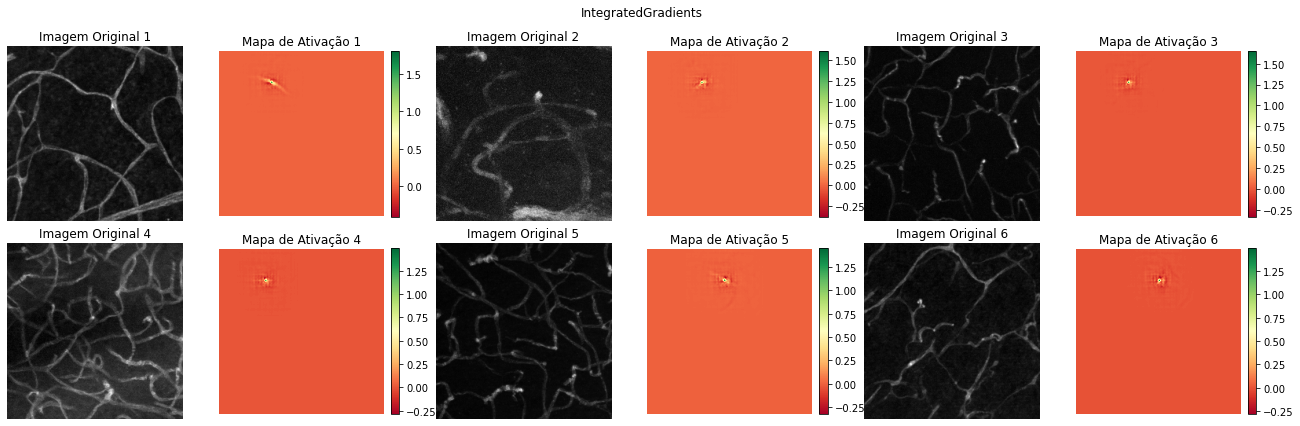

In [29]:
# IntregratedGradients method
path = "../attributions_maps/vessels/"
target = 1
dataset_type = 'vess_map'
# Usage
attributions = seg_attr.compute_attributions('IntegratedGradients', 
                                             model.final, 
                                             tgt=target,
                                             noise_tunnel = False)

seg_attr.plot_attributions_simple(attributions, input_images, title = 'IntegratedGradients' )

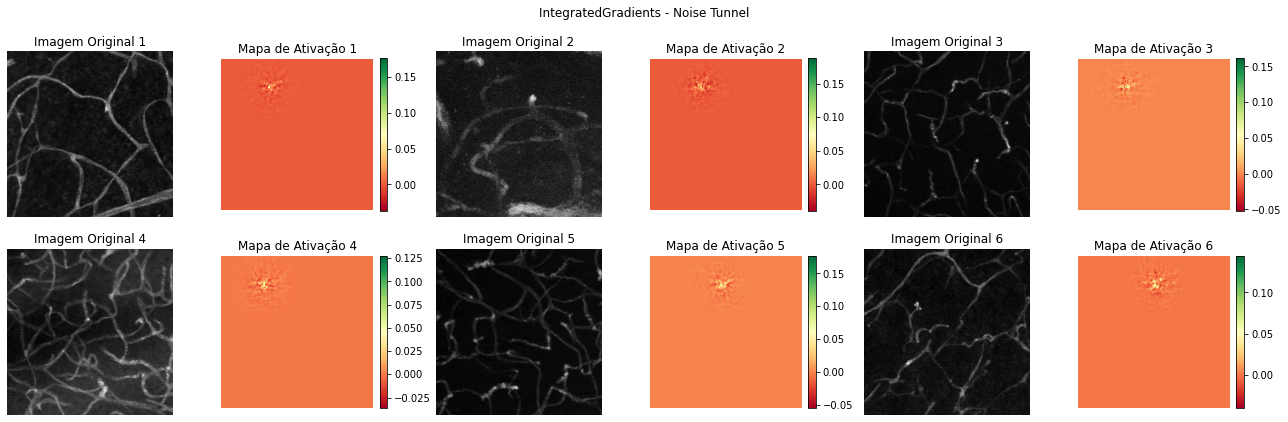

In [30]:
# IntregratedGradients method
path = "../attributions_maps/vessels/"
target = 1
dataset_type = 'vess_map'
# Usage
attributions = seg_attr.compute_attributions('IntegratedGradients', 
                                             model.final, 
                                             tgt=target,
                                             noise_tunnel = True,
                                             noise_tunnel_params=nt_variations,
                                             variations=[nt_variations])

seg_attr.plot_attributions_simple(attributions, input_images, title = 'IntegratedGradients - Noise Tunnel' )

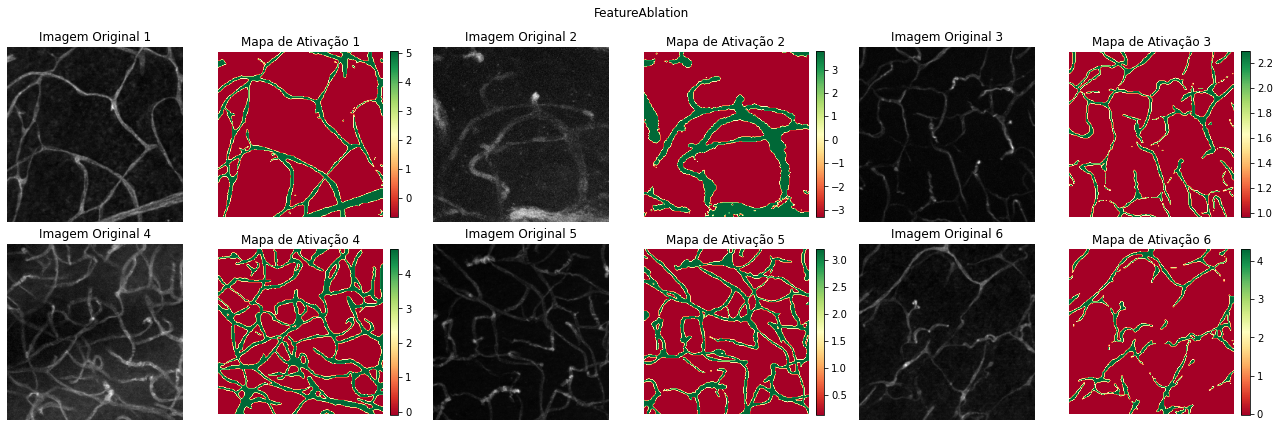

In [31]:
# FeatureAblation method
path = "../attributions_maps/vessels/"
target = 1
dataset_type = 'vess_map'
# Usage
attributions = seg_attr.compute_attributions('FeatureAblation', 
                                             model.final, 
                                             tgt=target,
                                             noise_tunnel = False)

seg_attr.plot_attributions_simple(attributions, input_images, title = 'FeatureAblation' )

In [32]:
""" # FeatureAblation method
path = "../attributions_maps/vessels/"
target = 1
dataset_type = 'vess_map'
# Usage
attributions = seg_attr.compute_attributions('FeatureAblation', 
                                             model.final, 
                                             tgt=target,
                                             noise_tunnel = True,
                                             noise_tunnel_params=nt_variations,
                                             variations=[nt_variations])

seg_attr.plot_attributions_simple(attributions, input_images, title = 'FeatureAblation - Noise Tunnel' ) """

' # FeatureAblation method\npath = "../attributions_maps/vessels/"\ntarget = 1\ndataset_type = \'vess_map\'\n# Usage\nattributions = seg_attr.compute_attributions(\'FeatureAblation\', \n                                             model.final, \n                                             tgt=target,\n                                             noise_tunnel = True,\n                                             noise_tunnel_params=nt_variations,\n                                             variations=[nt_variations])\n\nseg_attr.plot_attributions_simple(attributions, input_images, title = \'FeatureAblation - Noise Tunnel\' ) '

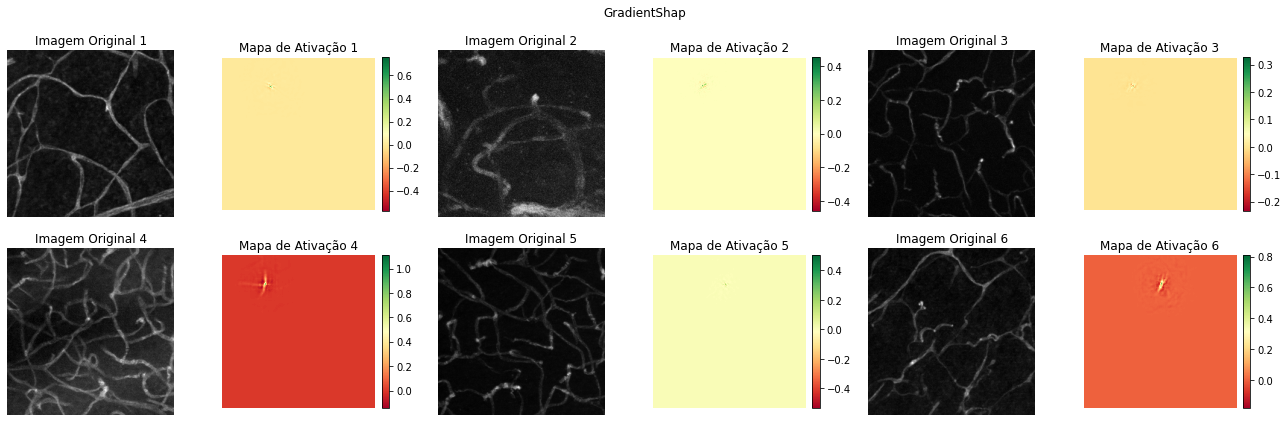

In [33]:
# GradientShap method
path = "../attributions_maps/vessels/"
target = 1
dataset_type = 'vess_map'
# Usage
attributions = seg_attr.compute_attributions('GradientShap', 
                                             model.final, 
                                             tgt=target,
                                             noise_tunnel = False)

seg_attr.plot_attributions_simple(attributions, input_images, title = 'GradientShap' )

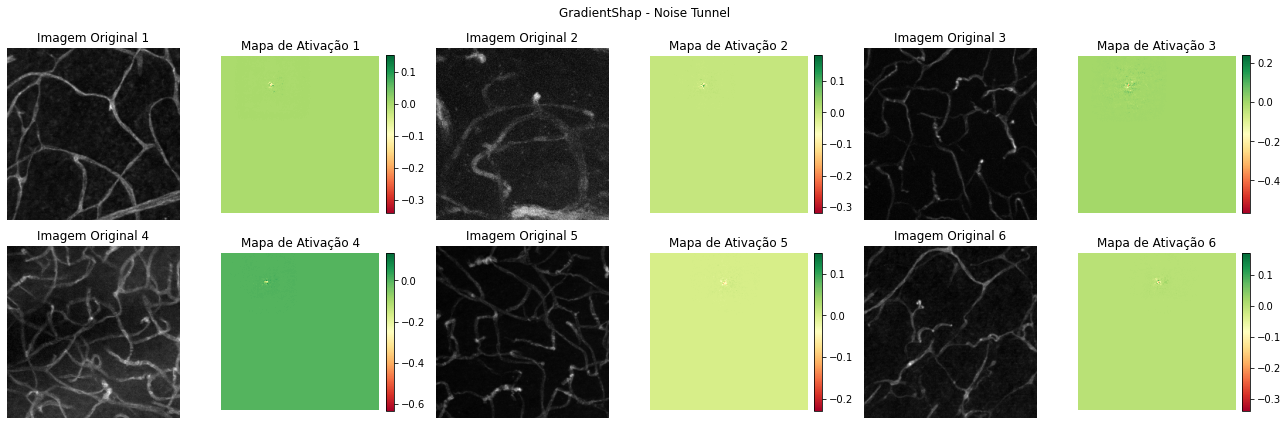

In [34]:
# GradientShap method
path = "../attributions_maps/vessels/"
target = 1
dataset_type = 'vess_map'
# Usage
attributions = seg_attr.compute_attributions('GradientShap', 
                                             model.final, 
                                             tgt=target,
                                             noise_tunnel = True,
                                             noise_tunnel_params=nt_variations,
                                             variations=[nt_variations])

seg_attr.plot_attributions_simple(attributions, input_images, title = 'GradientShap - Noise Tunnel' )

/home/fonta42/anaconda3/envs/interpreting-cnn/lib/python3.7/site-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


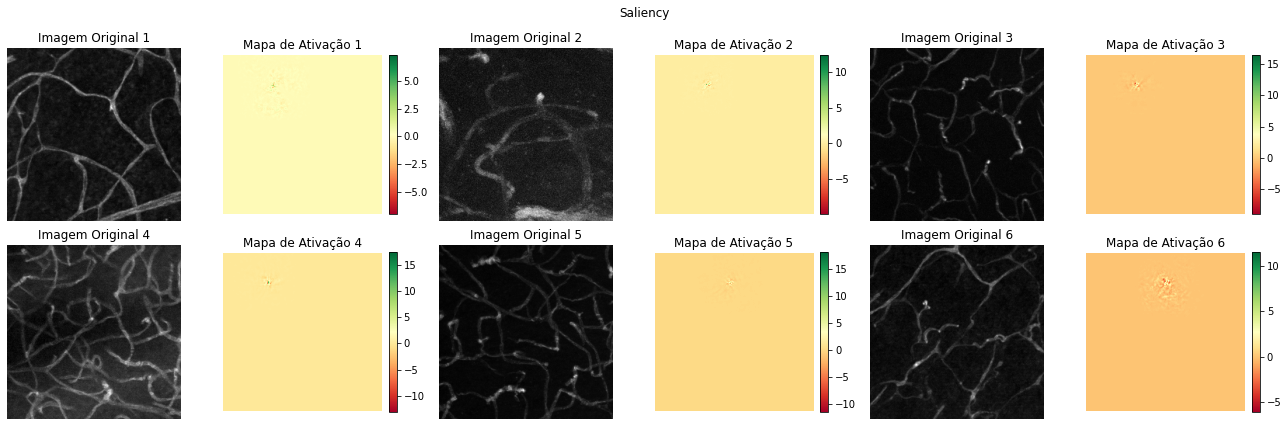

In [35]:
# Saliency method
path = "../attributions_maps/vessels/"
target = 1
dataset_type = 'vess_map'
# Usage
attributions = seg_attr.compute_attributions('Saliency', 
                                             model.final, 
                                             tgt=target,
                                             noise_tunnel = False)

seg_attr.plot_attributions_simple(attributions, input_images, title = 'Saliency' )

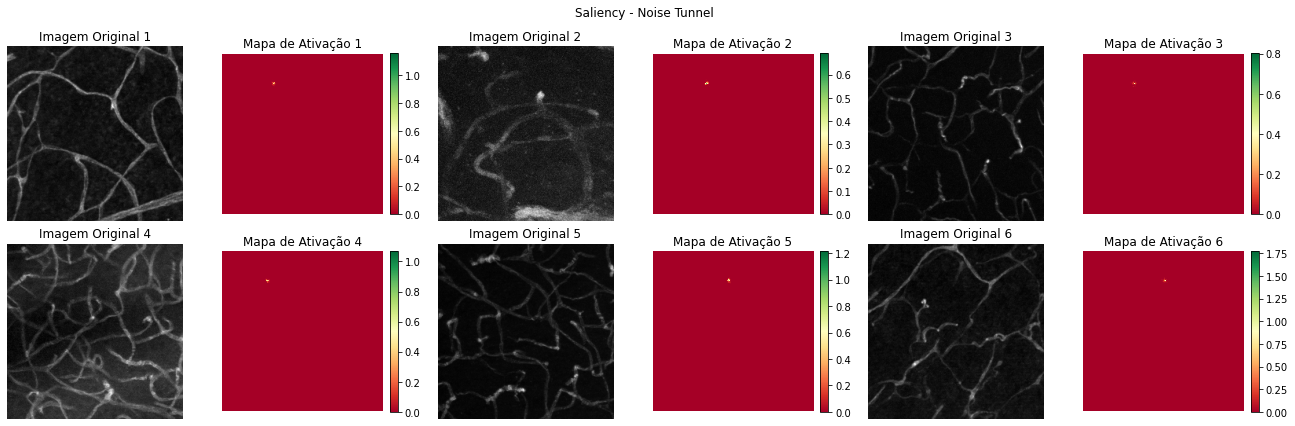

In [36]:
# Saliency method
path = "../attributions_maps/vessels/"
target = 1
dataset_type = 'vess_map'
# Usage
attributions = seg_attr.compute_attributions('Saliency', 
                                             model.final, 
                                             tgt=target,
                                             noise_tunnel = True,
                                             noise_tunnel_params=nt_variations,
                                             variations=[nt_variations])

seg_attr.plot_attributions_simple(attributions, input_images, title = 'Saliency - Noise Tunnel' )

In [37]:
# Saliency method
path = "../attributions_maps/vessels/"
target = 1
dataset_type = 'vess_map'
# Usage
attributions = seg_attr.compute_attributions('Saliency', 
                                             model.final, 
                                             tgt=target,
                                             noise_tunnel = False)

seg_attr.plot_attributions_simple(attributions, input_images) 

/home/fonta42/anaconda3/envs/interpreting-cnn/lib/python3.7/site-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


TypeError: plot_attributions_simple() missing 1 required positional argument: 'title'

In [ ]:
# Saliency + NoiseTunnel
path = "../attributions_maps/vessels/"
target = 1
dataset_type = 'vess_map'
# Usage
# Define NoiseTunnel variations with different parameters
nt_variations = [
    # Variations for nt_type 'smoothgrad'
    {'nt_type': 'smoothgrad', 'stdevs': 1., 'nt_samples': 10},
    {'nt_type': 'smoothgrad', 'stdevs': 10., 'nt_samples': 10},
    {'nt_type': 'smoothgrad', 'stdevs': 20., 'nt_samples': 10},
    
    # Variations for nt_type 'smoothgrad_sq'
    {'nt_type': 'smoothgrad_sq', 'stdevs': 1., 'nt_samples': 10},
    {'nt_type': 'smoothgrad_sq', 'stdevs': 10., 'nt_samples': 10},
    {'nt_type': 'smoothgrad_sq', 'stdevs': 20., 'nt_samples': 10},
    
    # Variations for nt_type 'vargrad'
    {'nt_type': 'vargrad', 'stdevs': 1., 'nt_samples': 10},
    {'nt_type': 'vargrad', 'stdevs': 10., 'nt_samples': 10},
    {'nt_type': 'vargrad', 'stdevs': 20., 'nt_samples': 10},
]


# Usage
for var_params in nt_variations:
    attributions = seg_attr.compute_attributions('Saliency',
                                                 model.final,
                                                 tgt=target,
                                                 noise_tunnel=True,
                                                 noise_tunnel_params=var_params,
                                                 variations=[var_params])

    # Include the parameters in the save path and title
    save_path = f"{path}SaliencyNoiseTunnel{target}_{dataset_type}_{'_'.join([f'{key}_{value}' for key, value in var_params.items()])}.png"
    title = f"SaliencyNoiseTunnel{target}_{dataset_type}_{'_'.join([f'{key}_{value}' for key, value in var_params.items()])}"

    seg_attr.plot_attributions(attributions,
                               save_path=save_path,
                               title=title) 


KeyboardInterrupt: 

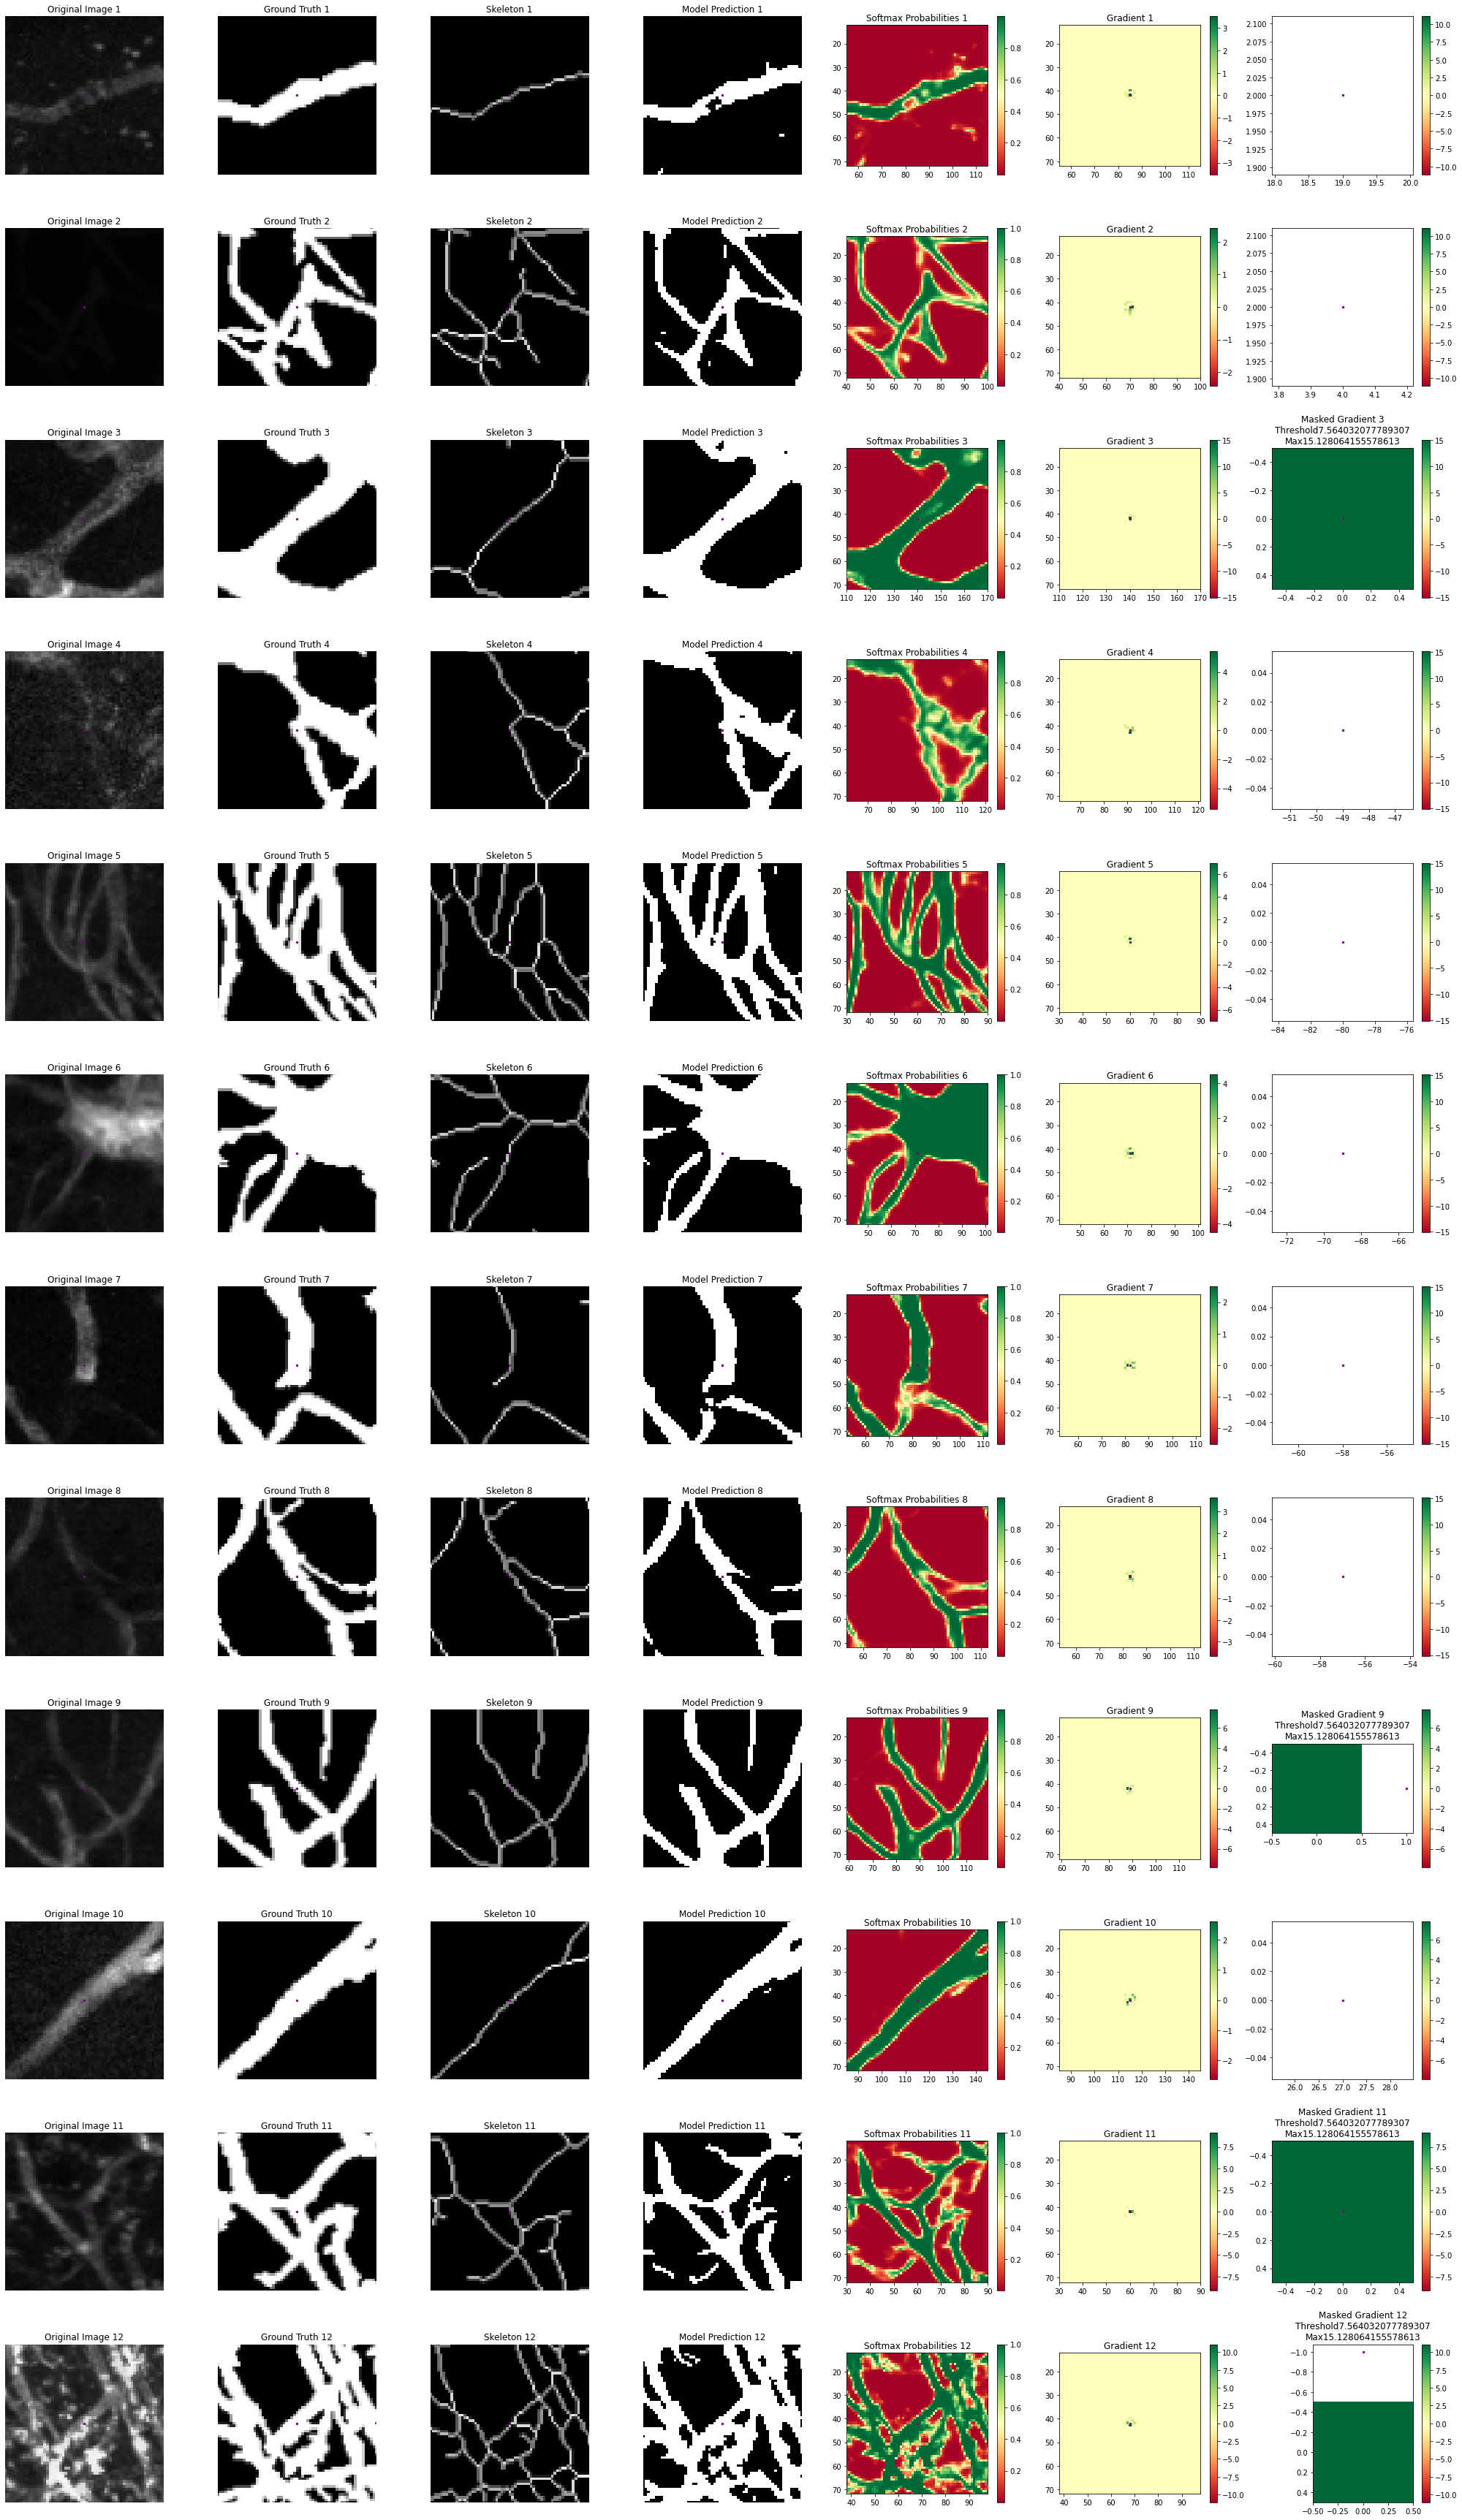

In [ ]:
# # Saliency + NoiseTunnel, plots analysis
coordinates = seg_attr.centroids

num_images = len(input_images)

max = np.max([np.max(np.abs(grad.detach().cpu().numpy())) for grad in attributions])
threshold = 0.005 * max

# Set the size of each individual subplot
subplot_size = (4, 4)  # Adjust as needed

# Calculate the total width and height of the figure
total_width = 7 * subplot_size[0]
total_height = num_images * subplot_size[1]

# Create the figure with the adjusted size
fig, axes = plt.subplots(num_images, 7, figsize=(total_width, total_height))

# Adjust spacing between subplots
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.5, wspace=0.2)  
for i in range(num_images):
    # Original Image Visualization
    original_img = input_images[i].detach().cpu().numpy().transpose(1, 2, 0)
    axes[i, 0].imshow(original_img, cmap='gray')
    axes[i, 0].set_title(f'Original Image {i+1}')
    
    
    # Original Mask Visualization
    original_mask = input_masks[i].detach().cpu().numpy().transpose(1, 2, 0)
    axes[i, 1].imshow(original_mask, cmap='gray')
    axes[i, 1].set_title(f'Ground Truth {i+1}')
    
    # Original Skeleton Visualization
    original_ske = input_skeletons[i].detach().cpu().numpy().transpose(1, 2, 0)
    axes[i, 2].imshow(original_ske, cmap='gray')
    axes[i, 2].set_title(f'Skeleton {i+1}')
    
    # Model (Mask)Output Visualization
    output = model(input_images[i].unsqueeze(0).to('cpu'))  
    out_max = torch.argmax(output, dim=1, keepdim=True)
    model_mask = out_max[0].detach().cpu().numpy()
    axes[i, 3].imshow(model_mask.transpose(1, 2, 0), cmap='gray')
    axes[i, 3].set_title(f'Model Prediction {i+1}')
    
    # Softmax Probabilities Visualization
    softmax_probs = F.softmax(output, dim=1)
    class_one_probs = softmax_probs[0, 1, :, :].detach().cpu().numpy()
    img_softmax = axes[i, 4].imshow(class_one_probs, cmap='RdYlGn', interpolation='nearest')
    axes[i, 4].set_title(f'Softmax Probabilities {i+1}')
    
    # Gradient Visualization
    gradient = attributions[i].squeeze()
    v_max = np.abs(gradient.detach().cpu().numpy()).max()

    img_grad = axes[i, 5].imshow(gradient.detach().cpu().numpy(), cmap='RdYlGn', vmin=-v_max, vmax=v_max, interpolation='nearest')
    axes[i, 5].set_title(f'Gradient {i+1}')
    
    
    # Create a mask where gradient values are above the threshold
    mask = np.abs(gradient.detach().cpu().numpy()) > threshold
    # Find the bounds of the relevant region
    non_zero_coords = np.nonzero(mask)
    if len(non_zero_coords[0]) > 0:
        # Getting coordinates
        y_min, y_max = non_zero_coords[0].min(), non_zero_coords[0].max()
        x_min, x_max = non_zero_coords[1].min(), non_zero_coords[1].max()
        relevant_region = gradient[y_min:y_max+1, x_min:x_max+1].detach().cpu().numpy()
        v_max = np.abs(relevant_region).max()
        img_masked_grad = axes[i, 6].imshow(relevant_region, cmap='RdYlGn', vmin=-v_max, vmax=v_max, interpolation='nearest')
        axes[i, 6].set_title(f'Masked Gradient {i+1}\nThreshold{threshold}\nMax{max}')


    # Highlight the specified pixel and zoom in
    coord = coordinates[i]
    for ax in axes[i, :6]:
        ax.scatter(coord[0], coord[1], color='purple', s=6)
        ax.set_xlim((coord[0] - 30, coord[0] + 30))
        ax.set_ylim((coord[1] + 30, coord[1] - 30))

    axes[i, 6].scatter(coord[0] - x_min, coord[1] - y_min, color='purple', s=6)
    
    for ax in axes[i, :4]:
        ax.axis('off')
        
    # Add colorbars
    fig.colorbar(img_softmax, ax=axes[i, 4], orientation='vertical')
    fig.colorbar(img_grad, ax=axes[i, 5], orientation='vertical')
    fig.colorbar(img_masked_grad, ax=axes[i, 6], orientation='vertical')

plt.tight_layout()
plt.show()

In [ ]:
# # Saliency + NoiseTunnel, region of pixels
path = "../attributions_maps/vessels/"
target = 1
dataset_type = 'vess_map'
# Usage
attributions = seg_attr.compute_attributions('Saliency', 
                                             model.final, 
                                             tgt=target,
                                             noise_tunnel = True,
                                             wrapper_type = "pix_region")

seg_attr.plot_attributions(attributions, 
                           save_path=f"{path}Saliency{target}_{dataset_type}",
                           title=f"SaliencyNoiseTunnel{target}_{dataset_type}") 


TypeError: 'NoneType' object is not iterable

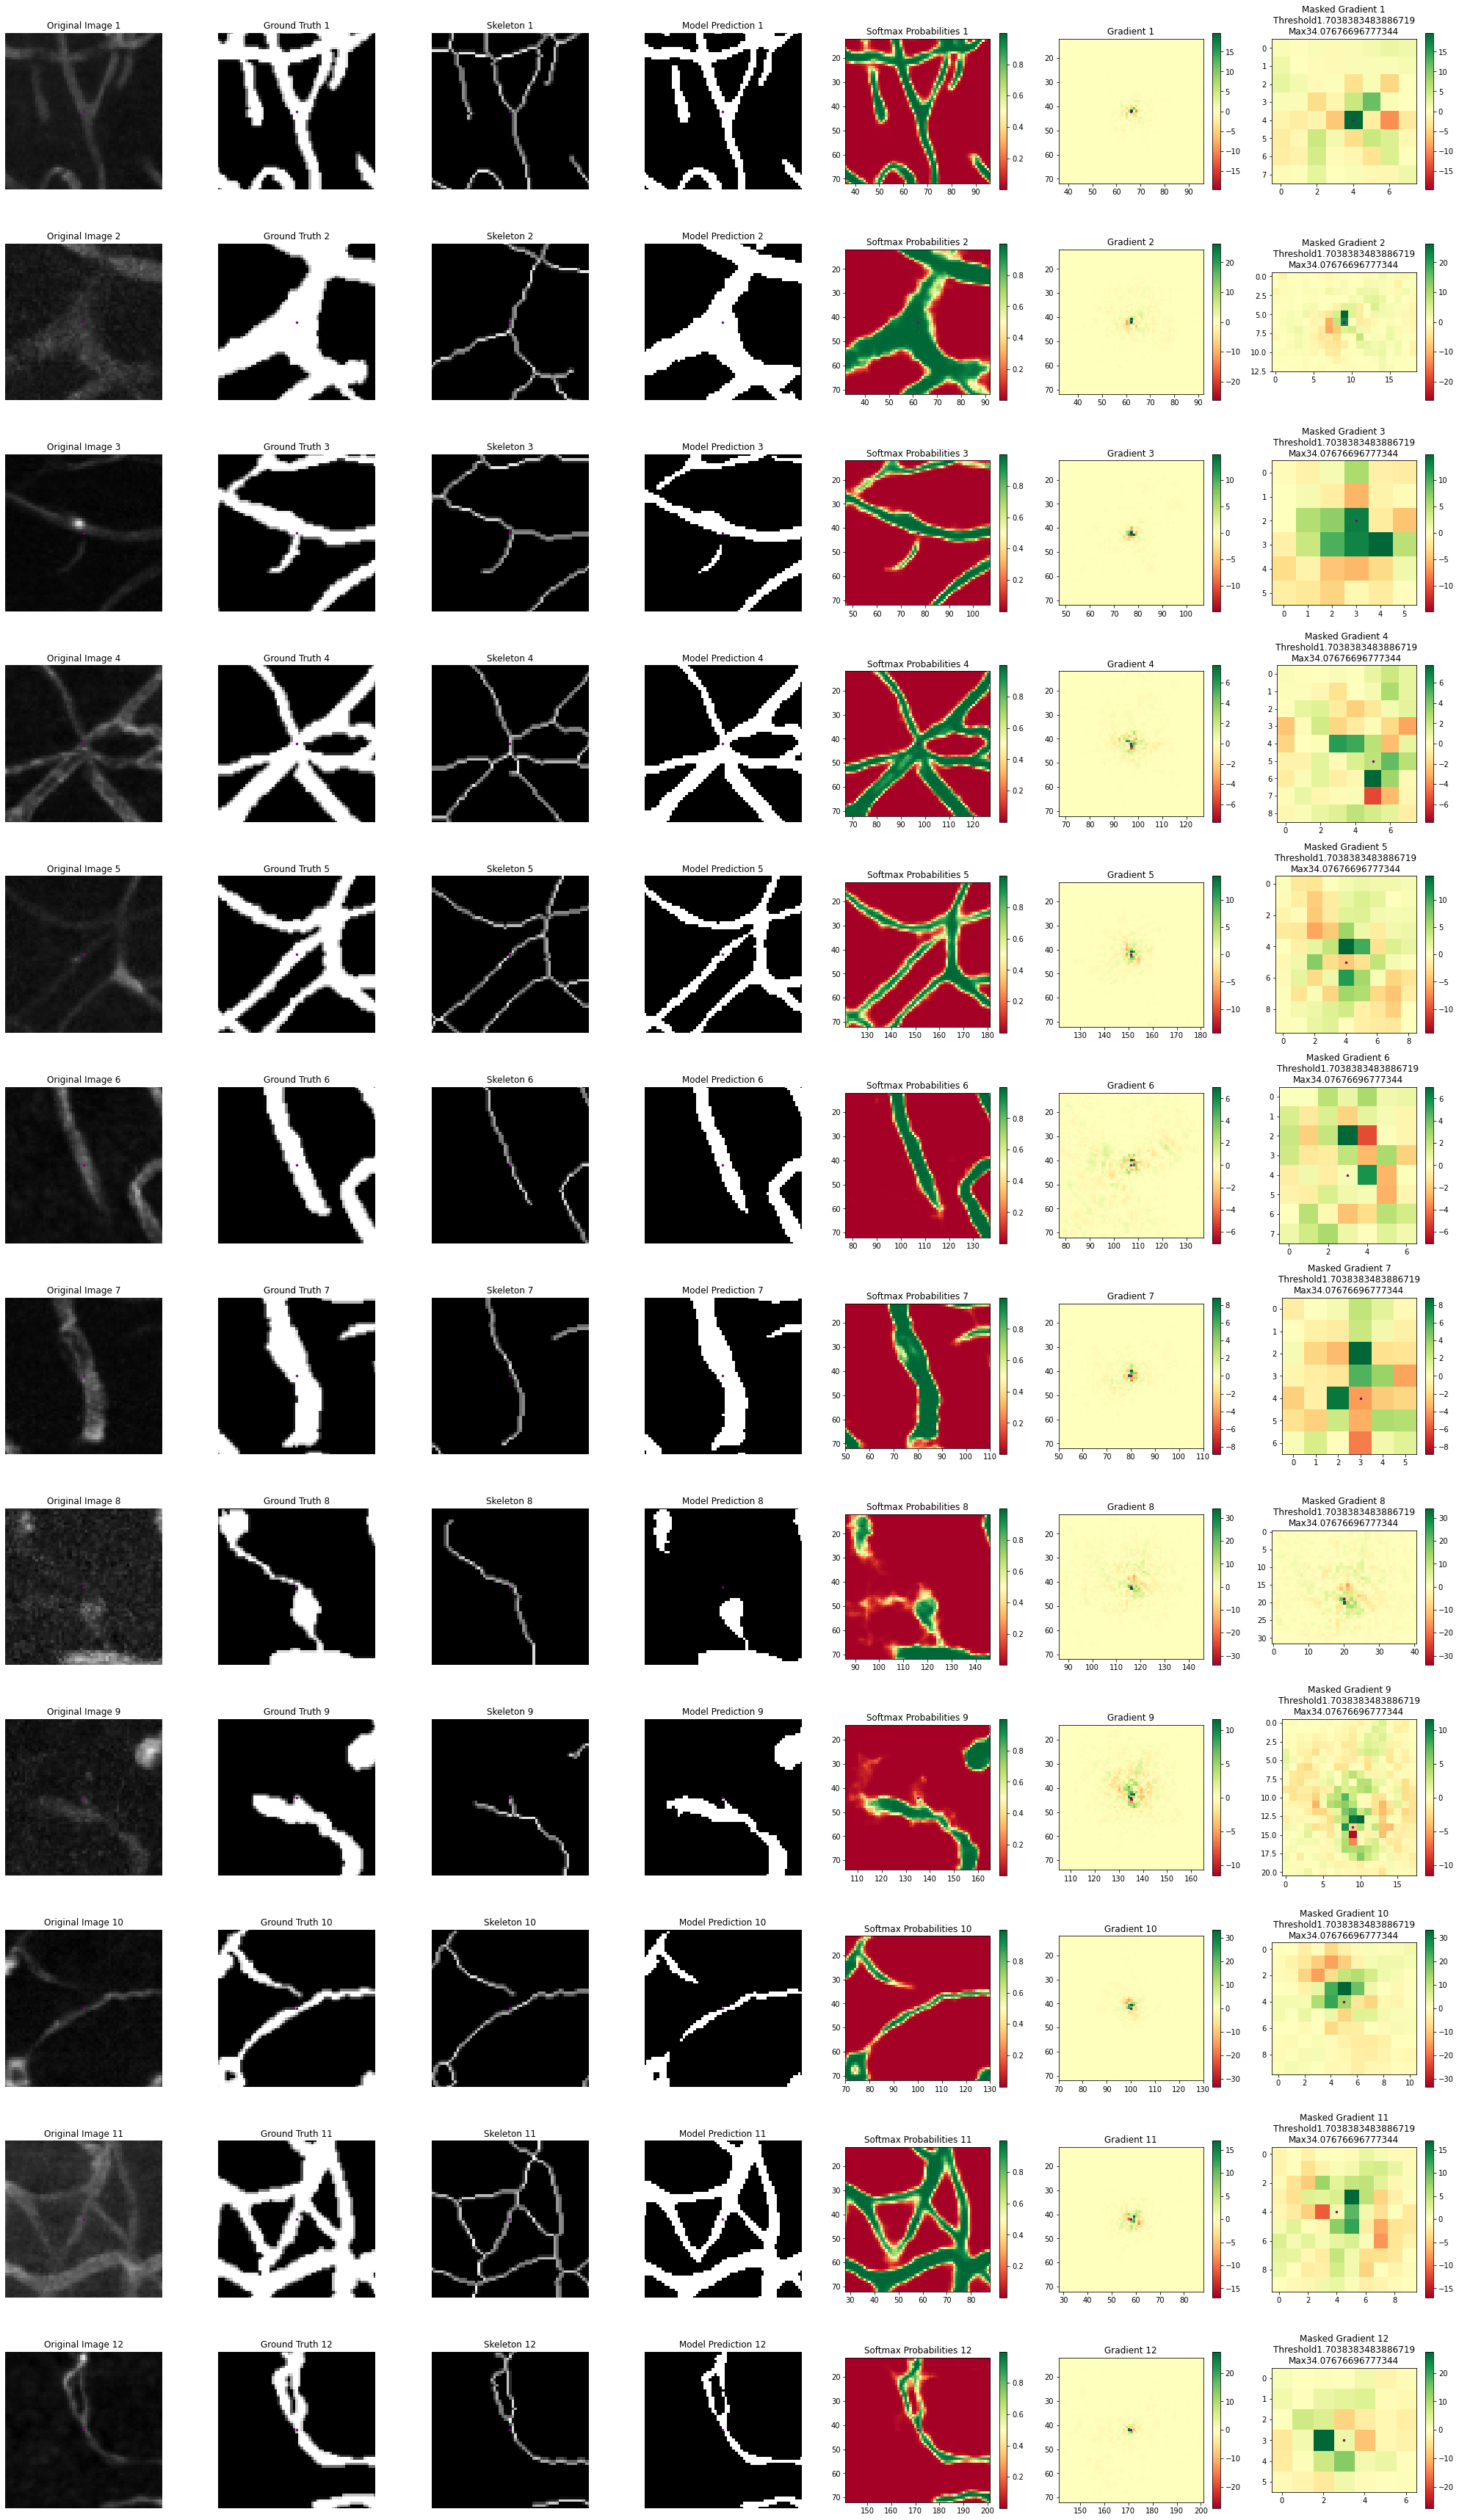

In [ ]:
coordinates = seg_attr.centroids

num_images = len(input_images)

max = np.max([np.max(np.abs(grad.detach().cpu().numpy())) for grad in attributions])
threshold = 0.05 * max

# Set the size of each individual subplot
subplot_size = (4, 4)  # Adjust as needed

# Calculate the total width and height of the figure
total_width = 7 * subplot_size[0]
total_height = num_images * subplot_size[1]

# Create the figure with the adjusted size
fig, axes = plt.subplots(num_images, 7, figsize=(total_width, total_height))

# Adjust spacing between subplots
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.5, wspace=0.2)  
for i in range(num_images):
    # Original Image Visualization
    original_img = input_images[i].detach().cpu().numpy().transpose(1, 2, 0)
    axes[i, 0].imshow(original_img, cmap='gray')
    axes[i, 0].set_title(f'Original Image {i+1}')
    
    
    # Original Mask Visualization
    original_mask = input_masks[i].detach().cpu().numpy().transpose(1, 2, 0)
    axes[i, 1].imshow(original_mask, cmap='gray')
    axes[i, 1].set_title(f'Ground Truth {i+1}')
    
    # Original Skeleton Visualization
    original_ske = input_skeletons[i].detach().cpu().numpy().transpose(1, 2, 0)
    axes[i, 2].imshow(original_ske, cmap='gray')
    axes[i, 2].set_title(f'Skeleton {i+1}')
    
    # Model (Mask)Output Visualization
    output = model(input_images[i].unsqueeze(0))  
    out_max = torch.argmax(output, dim=1, keepdim=True)
    model_mask = out_max[0].detach().cpu().numpy()
    axes[i, 3].imshow(model_mask.transpose(1, 2, 0), cmap='gray')
    axes[i, 3].set_title(f'Model Prediction {i+1}')
    
    # Softmax Probabilities Visualization
    output = model(input_images[i].unsqueeze(0))  
    softmax_probs = F.softmax(output, dim=1)
    class_one_probs = softmax_probs[0, 1, :, :].detach().cpu().numpy()
    img_softmax = axes[i, 4].imshow(class_one_probs, cmap='RdYlGn', interpolation='nearest')
    axes[i, 4].set_title(f'Softmax Probabilities {i+1}')
    
    # Gradient Visualization
    gradient = attributions[i].squeeze()
    v_max = np.abs(gradient.detach().cpu().numpy()).max()

    img_grad = axes[i, 5].imshow(gradient.detach().cpu().numpy(), cmap='RdYlGn', vmin=-v_max, vmax=v_max, interpolation='nearest')
    axes[i, 5].set_title(f'Gradient {i+1}')
    
    
    # Create a mask where gradient values are above the threshold
    mask = np.abs(gradient.detach().cpu().numpy()) > threshold
    # Find the bounds of the relevant region
    non_zero_coords = np.nonzero(mask)
    if len(non_zero_coords[0]) > 0:
        # Getting coordinates
        y_min, y_max = non_zero_coords[0].min(), non_zero_coords[0].max()
        x_min, x_max = non_zero_coords[1].min(), non_zero_coords[1].max()
        relevant_region = gradient[y_min:y_max+1, x_min:x_max+1].detach().cpu().numpy()
        v_max = np.abs(relevant_region).max()
        img_masked_grad = axes[i, 6].imshow(relevant_region, cmap='RdYlGn', vmin=-v_max, vmax=v_max, interpolation='nearest')
        axes[i, 6].set_title(f'Masked Gradient {i+1}\nThreshold{threshold}\nMax{max}')


    # Highlight the specified pixel and zoom in
    coord = coordinates[i]
    for ax in axes[i, :6]:
        ax.scatter(coord[0], coord[1], color='purple', s=6)
        ax.set_xlim((coord[0] - 30, coord[0] + 30))
        ax.set_ylim((coord[1] + 30, coord[1] - 30))

    axes[i, 6].scatter(coord[0] - x_min, coord[1] - y_min, color='purple', s=6)
    
    for ax in axes[i, :4]:
        ax.axis('off')
        
    # Add colorbars
    fig.colorbar(img_softmax, ax=axes[i, 4], orientation='vertical')
    fig.colorbar(img_grad, ax=axes[i, 5], orientation='vertical')
    fig.colorbar(img_masked_grad, ax=axes[i, 6], orientation='vertical')

plt.tight_layout()
plt.show()